Project 3 Prep:

First: Have a copy of the files for Colab for refrence as this code doesn't pull them from drive or a github repository.

Second: Ensure that PyTorch and other needed libraries are accessiable. If you are downloading this code and not running through colab, connected to the internet, you will need them on device.

In [2]:
#Import files from device to process.
from google.colab import files
uploaded = files.upload()

#Import required data processing libraries.
import h5py
import numpy as np

# Initialize data structures for LFP recordings and segment counts
lfp = {'NREM': [], 'WAKE': []}
segment_counts = {'NREM': 0, 'WAKE': 0}

# Loop over each uploaded file
for filename in uploaded.keys():
    print(f'Processing file "{filename}" with length {len(uploaded[filename])} bytes')
    with h5py.File(filename, 'r') as f:  # Open the file
        # Assuming 'fs' is a global attribute for sampling frequency
        fs = f.attrs['fs'][0]
        print(f"Sampling rate: {fs:.1f} Hz")

        # Loop over states in each file
        for state in f.keys():
            group = f[state]  # Access the group corresponding to the state
            segment_ids = list(group.keys())  # List segment IDs within the state

            # Update the count of segments for the state
            segment_counts[state] += len(segment_ids)

            # Extract and store segment data from each file
            for segment_id in segment_ids:
                segment_data = np.array(group[segment_id]).astype(float)
                lfp[state].append(segment_data)

# Print the total number of segments for each state
for state, count in segment_counts.items():
    print(f"Total segments for state '{state}': {count}")

Saving Part1SubjectHB10.h5 to Part1SubjectHB10.h5
Saving Part2SubjectHB13.h5 to Part2SubjectHB13.h5
Saving Rat08-20130711_017.h5 to Rat08-20130711_017.h5
Processing file "Part1SubjectHB10.h5" with length 9109466 bytes
Sampling rate: 1000.0 Hz
Processing file "Part2SubjectHB13.h5" with length 9170192 bytes
Sampling rate: 1000.0 Hz
Processing file "Rat08-20130711_017.h5" with length 46559900 bytes
Sampling rate: 1250.0 Hz
Total segments for state 'NREM': 95
Total segments for state 'WAKE': 97


The printout and secion above is to ensure proper data upload and reading test before the program continues.

Note that the imported data byte count should match the printed listing to ensure that no cutting has occured.

Also note that the segment totals are an aggregate from all files so in processing all WAKE vs NREM segments will be compared to each other for pattern maping in the ML program.

Now that all files are opened and and each set NREM and WAKE are classified and the total found we need to extract each states data for processing.

In [3]:
import h5py
import numpy as np

for filepath in uploaded:
    print(f"\nProcessing file: {filepath}")

    # Open the HDF5 file
    f = h5py.File(filepath, 'r')

    # Initialize states based on the groups found in the HDF5 file
    states = list(f.keys())  # This assumes all top-level groups represent different states (e.g., 'NREM', 'WAKE')

    # Print basic file attributes and states found
    fs = f.attrs['fs'][0]  # Sampling frequency
    print(f"  Sampling rate: {fs:.1f} Hz")
    print(f"  States found: {states}")

    # Initialize data structures for LFP recordings and segment counts
    lfp = {state: [] for state in states}
    segment_counts = {state: 0 for state in states}

    for state in states:
        group = f[state]  # Access the group corresponding to the state
        segment_ids = list(group.keys())  # List segment IDs within the state
        segment_counts[state] = len(segment_ids)  # Count segments for the state

        for segment_id in segment_ids:
            # Extract and store segment data
            segment_data = np.array(group[segment_id]).astype(float)
            lfp[state].append(segment_data)

    # Print the number of segments for each state
    for state, count in segment_counts.items():
        print(f"  State: {state}, Number of segments: {count}")

    f.close()


Processing file: Part1SubjectHB10.h5
  Sampling rate: 1000.0 Hz
  States found: ['NREM', 'WAKE']
  State: NREM, Number of segments: 17
  State: WAKE, Number of segments: 38

Processing file: Part2SubjectHB13.h5
  Sampling rate: 1000.0 Hz
  States found: ['NREM', 'WAKE']
  State: NREM, Number of segments: 19
  State: WAKE, Number of segments: 22

Processing file: Rat08-20130711_017.h5
  Sampling rate: 1250.0 Hz
  States found: ['NREM', 'WAKE']
  State: NREM, Number of segments: 59
  State: WAKE, Number of segments: 37


This is the number of each segment for each state form each file. The sum of all is equal to the first segment counts indpendent of each file.

NREM: 95

WAKE: 97

Extract and visualize the data:


Extract segments within each state and visualize some of the segments for use as training data.


Plotting 2 segment(s) from state: NREM


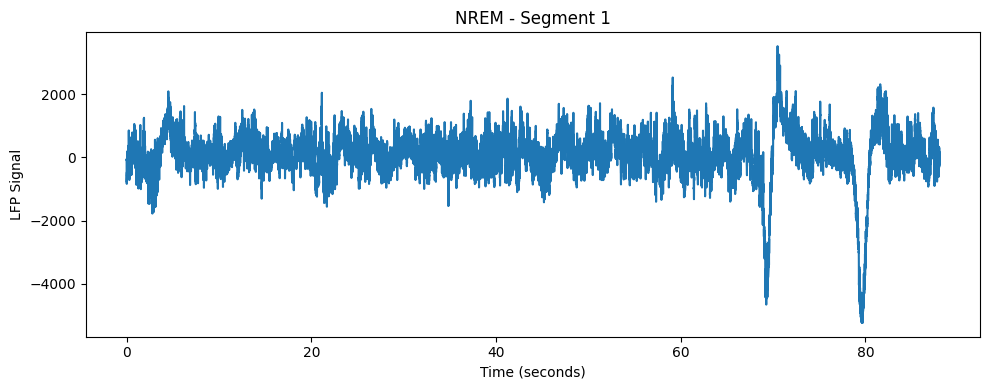

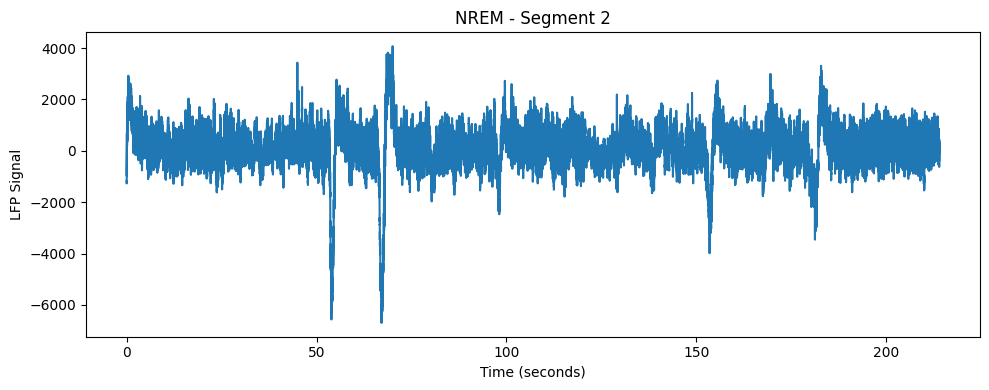


Plotting 2 segment(s) from state: WAKE


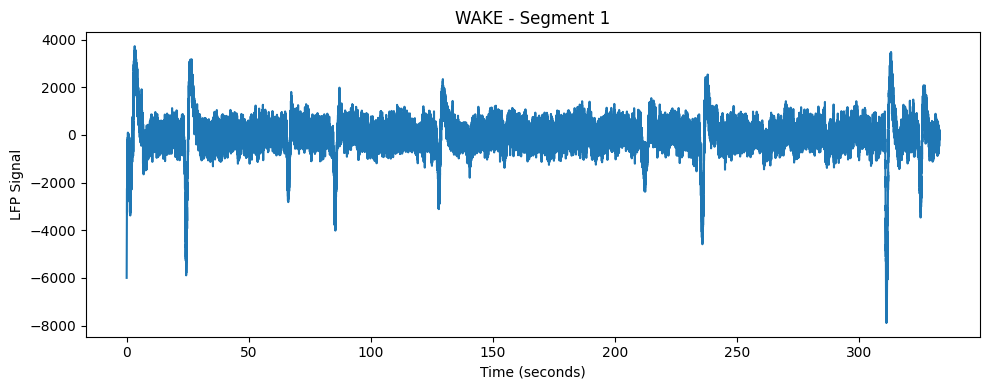

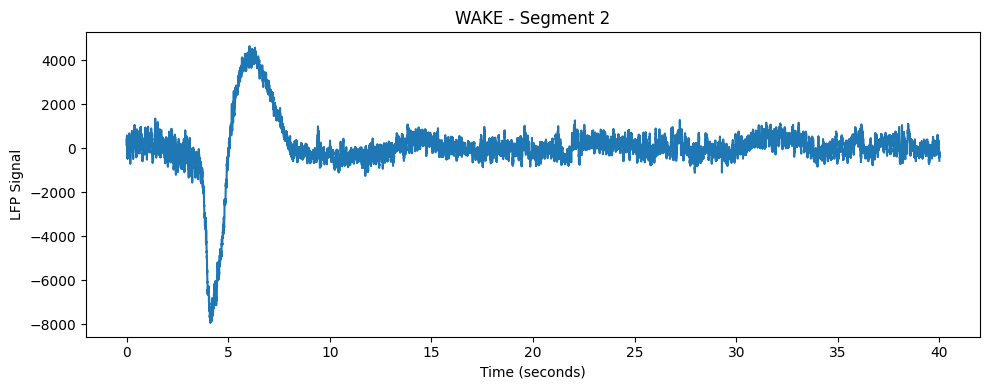

In [15]:
import matplotlib.pyplot as plt
import numpy as np

states_to_plot = ['NREM', 'WAKE']   # States you're interested in
num_segments_to_plot = 2           # Number of segments to show per state

for state in states_to_plot:
    if state in lfp:
        total_segments = segment_counts[state]
        segments_to_plot = min(num_segments_to_plot, total_segments)

        print(f"\nPlotting {segments_to_plot} segment(s) from state: {state}")

        for i in range(segments_to_plot):
            x = lfp[state][i]
            t = np.arange(len(x)) / fs  # Time axis

            plt.figure(figsize=(10, 4))
            plt.plot(t, x)
            plt.xlabel('Time (seconds)')
            plt.ylabel('LFP Signal')
            plt.title(f'{state} - Segment {i+1}')
            plt.tight_layout()
            plt.show()
    else:
        print(f"State '{state}' not found in the data.")


Now that the data has been visualized in its raw form for several segments samples for training data need to be extracted for each set.

In [14]:
# Ensure sampling_rate and clip_duration are defined correctly
sampling_rate = int(fs)  # Convert to integer if not already
clip_duration = 5  # Duration in seconds (4.5 also works but model accuracy per eppch count will change. Remember small the duration less accurate the sampling predictions.)

# Calculate samples per clip and explicitly convert to integer
samples_per_clip = int(clip_duration * sampling_rate)

# Create data_dict using the existing lfp and segment_counts data
data_dict = {}
# Assume your labels are based on the states ('NREM' and 'WAKE')
# Modify the label assignment if you have a different labeling scheme
for state in lfp:  # lfp contains segments for each state
    data_dict[state] = {
        'segments': lfp[state],  # lfp[state] contains your segments
        'labels': [0 if state == 'NREM' else 1] * len(lfp[state]) # Create labels - 0 for NREM, 1 for WAKE
    }

default_fs = sampling_rate  # Assuming the sampling rate is the same for all data
segment_length = samples_per_clip  # Use samples_per_clip to define segment length

lfp_clips = {}       # dictionary to hold fixed-length clips (per subject)
clip_labels = {}     # dictionary to hold label for each clip

for rat, data in data_dict.items():
    fs = data.get("fs", default_fs)
    seg_list = data["segments"]  # list of variable-length segments
    label_list = data["labels"]  # list of corresponding labels
    clips = []
    labels_out = []
    for seg, lab in zip(seg_list, label_list):
        if len(seg) >= segment_length:
            n_clips = len(seg) // segment_length
            seg_trunc = seg[:n_clips * segment_length]  # truncate extra samples
            seg_clips = seg_trunc.reshape(n_clips, segment_length)
            clips.append(seg_clips)
            # Each clip gets the parent segment's label
            labels_out.extend([lab] * n_clips)
        else:
            continue  # skip segments that are too short
    # Concatenate clips along axis 0 for each subject
    if clips:
        clips = np.concatenate(clips, axis=0)
    else:
        clips = np.empty((0, segment_length))
    lfp_clips[rat] = clips
    clip_labels[rat] = np.array(labels_out)
    print(f"{rat}: segmented into {clips.shape[0]} clips of 5s each")


NREM: segmented into 1239 clips of 5s each
WAKE: segmented into 2443 clips of 5s each


Now the number of testing segments from the data are known and the sample data processing can begin.

In [8]:
from scipy.stats import skew, kurtosis

# Initialize a dictionary to hold the clip data along with their computed features for each state
clip_features = {'NREM': [], 'WAKE': []}

# Iterate over the lfp_clips dictionary (which contains clips for each state)
for state, state_clips in lfp_clips.items():  # Get both the state (key) and the clips (value)
    for clip in state_clips:  # Now iterate over the clips for the current state
        # Calculate various statistics for the current clip
        clip_mean = np.mean(clip)
        clip_std = np.std(clip)
        clip_skewness = skew(clip)
        clip_kurtosis = kurtosis(clip)
        #clip_entropy = entropy(np.histogram(clip, bins=10)[0])

        # Append the clip and its computed features as a dictionary to the state's list
        clip_features[state].append({
            'clip': clip,
            'mean': clip_mean,
            'std': clip_std,
            'skewness': clip_skewness,
            'kurtosis': clip_kurtosis,
            #'entropy': clip_entropy
        })

# Accessing and displaying the features of the first clip for 'NREM' state
first_nrem_clip_features = clip_features['NREM'][0]
print("Features of the first 'NREM' clip:")
print(f"Mean: {first_nrem_clip_features['mean']}")
print(f"STD: {first_nrem_clip_features['std']}")
print(f"Skewness: {first_nrem_clip_features['skewness']}")
print(f"Kurtosis: {first_nrem_clip_features['kurtosis']}")

# If original signa still needed:
example_clip = first_nrem_clip_features['clip']


Features of the first 'NREM' clip:
Mean: 34.792
STD: 698.1702320322745
Skewness: 0.21606066352768008
Kurtosis: -0.48215938742358544


With this complete the feature engineering for teh ML is prepared and the statistical profiles can be used.

PSD calculations using a small portion of the clip, aproximatly 1/4th of the total clip length, to reduce data point array size and enable smoother prediction line maping.

Sometimes small or larger portions of segments may need to be used based on how large each segment is, for this Colab it is 5 seconds so over cutting would be more likely and detremetal to the ML model, but if segments are 10 or 15 seconds long for other models then a greater cutting ratio of 1/8th or 1/10th might be prudent.


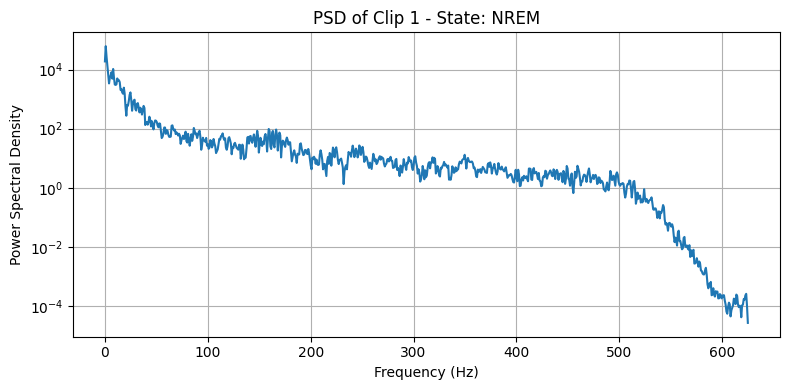

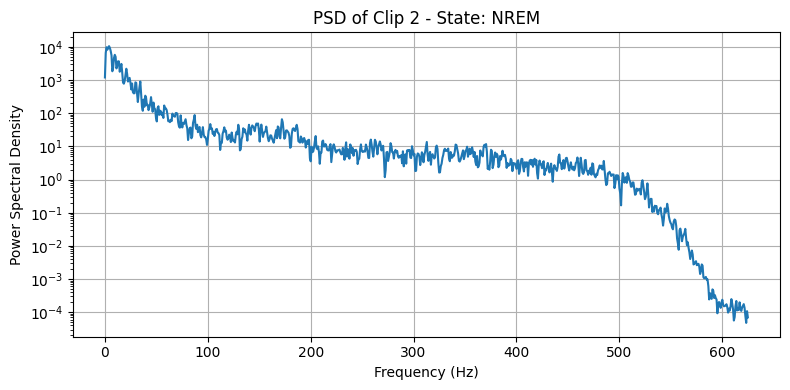

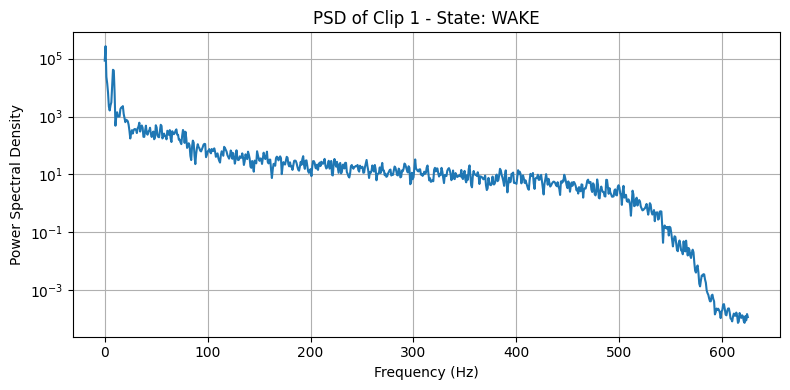

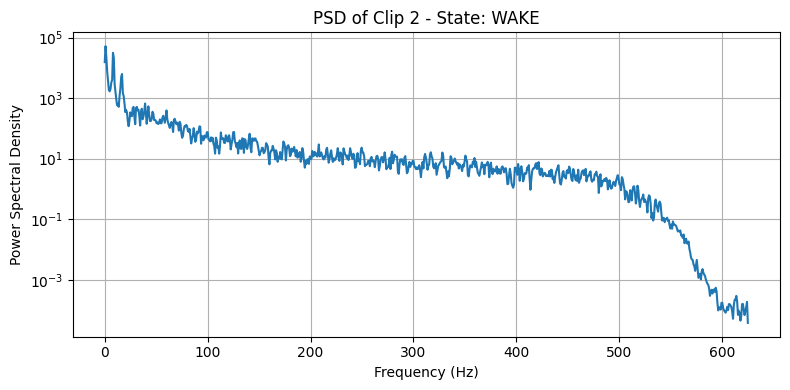

In [21]:
from scipy.signal import welch
import matplotlib.pyplot as plt

# Initialize a new key in the dictionary for PSD
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip = clip_feature['clip']

        # Choose nperseg as a fraction of the clip length for lower frequency resolution
        # Example: Using 1/4th of the clip length
        nperseg = len(clip) // 4

        # Calculate the PSD using Welch's method
        frequencies, psd = welch(clip, fs=sampling_rate, nperseg=nperseg)

        # Store the PSD data in the clip's feature dictionary
        clip_feature['psd'] = psd
        clip_feature['frequencies'] = frequencies

# Choose the state(s) and how many clips to plot from each
states_to_plot = ['NREM', 'WAKE']
num_clips_to_plot = 2  # How many clips to plot per state

for state in states_to_plot:
    clips = clip_features.get(state, [])[:num_clips_to_plot]

    for i, clip_feature in enumerate(clips):
        freqs = clip_feature['frequencies']
        psd = clip_feature['psd']

        plt.figure(figsize=(8, 4))
        plt.semilogy(freqs, psd)
        plt.title(f'PSD of Clip {i+1} - State: {state}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Now to find oscillation frequency bands in the PSD of each state to identify where the largest frequency band and use it as a feature in the ML program.

In [35]:
from scipy.signal import butter, sosfilt
from scipy.stats import ttest_ind
import numpy as np

# Define frequency bands (all tests bands for WAKE vs NREM)
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 80)
}

# Function to bandpass filter signal
def bandpass_filter(data, lowcut, highcut, fs, order=6):
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data)

# Compute band power for each clip and store
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip = clip_feature['clip']
        if 'band_stats' not in clip_feature:
            clip_feature['band_stats'] = {}

        for band_name, (lowcut, highcut) in bands.items():
            filtered = bandpass_filter(clip, lowcut, highcut, fs=sampling_rate)
            power = np.mean(filtered**2)
            clip_feature['band_stats'][band_name] = {'mean_power': power}

# Gather mean powers for each state and band
band_powers_by_state = {band: {'NREM': [], 'WAKE': []} for band in bands}
for state in ['NREM', 'WAKE']:
    for clip_feature in clip_features[state]:
        for band in bands:
            band_powers_by_state[band][state].append(clip_feature['band_stats'][band]['mean_power'])

# Perform t-tests between NREM and WAKE for each band
print("\n📊 Statistical Comparison of Band Power (NREM vs WAKE):")
for band in bands:
    nrem = band_powers_by_state[band]['NREM']
    wake = band_powers_by_state[band]['WAKE']

    t_stat, p_value = ttest_ind(nrem, wake, equal_var=False)  # Welch's t-test
    significance = "✅ Significant" if p_value < 0.05 else "❌ Not Significant"
    print(f"{band.upper():<6} | p = {p_value:.4f} | {significance}")


📊 Statistical Comparison of Band Power (NREM vs WAKE):
DELTA  | p = 0.0010 | ✅ Significant
THETA  | p = 0.0042 | ✅ Significant
ALPHA  | p = 0.0000 | ✅ Significant
BETA   | p = 0.0000 | ✅ Significant
GAMMA  | p = 0.0000 | ✅ Significant


Normalize the features to smooth fit lines and fortify against local extrema.

In [36]:
from scipy.stats import zscore

# First, flatten features values to apply normalization
mean_powers = [clip_feature['band_stats']['theta']['mean_power'] for state in clip_features for clip_feature in clip_features[state]]

# Apply Z-score normalization
mean_powers_normalized = zscore(mean_powers)

# Update original data structure with normalized values
i = 0  # Initialize a counter to track the current index in normalized values
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip_feature['band_stats']['theta']['mean_power_normalized'] = mean_powers_normalized[i]
        i += 1


Separate processed data into training, testing, and cross validation sections randomly.

Note the ratios used for this were the majority is used to train (60%) and only a small secion is used for validation (20%) and testing (20%).  

In [37]:
from sklearn.model_selection import train_test_split

# Example ratios
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# Prepare features and labels
features = []
labels = []  # Assuming 0 for NREM and 1 for WAKE

for state in clip_features:
    for clip_feature in clip_features[state]:
        # Assuming mean_power_normalized and std as the features for simplicity
        mean_power_normalized = clip_feature['band_stats']['theta']['mean_power_normalized']
        std_power = clip_feature['std'] # This key does not exist!

        # Create a feature vector for each clip
        feature_vector = [mean_power_normalized, std_power]
        features.append(feature_vector)

        # Append the label
        label = 0 if state == 'NREM' else 1
        labels.append(label)

# Convert to NumPy arrays for easier manipulation
features = np.array(features)
labels = np.array(labels)

# Splitting the dataset into training, validation, and testing sets
# First, split into training and temporary sets (temp will be further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, train_size=train_ratio, random_state=42)

# Calculate the split ratio for validation
validation_size = validation_ratio / (validation_ratio + test_ratio)

# Now split the temporary set into validation and test sets
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=42)

Once he data is processed into features and separated into test, train, and cross validation the actual traning is done using pytorch.


Final Epoch (50):
Validation Loss: 0.6349
Validation Accuracy: 66.71%


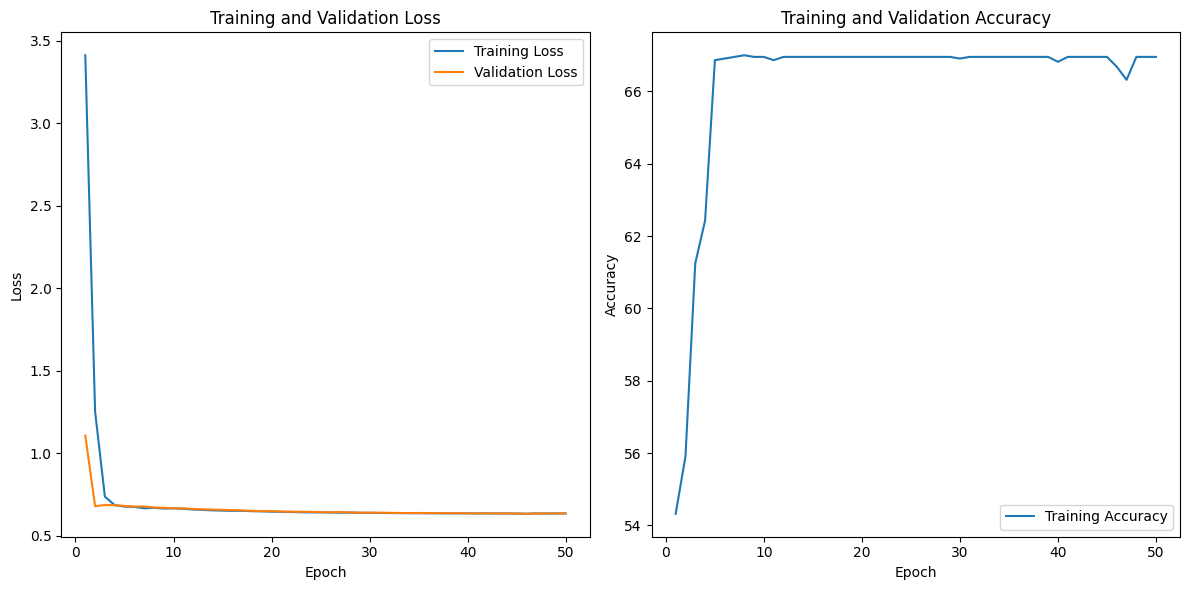

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class CNNSignalNet(nn.Module):
    def __init__(self, sequence_length, output_size):
        super(CNNSignalNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)

        # Calculate the size after convolutional layers (without pooling)
        # The size remains the same if stride is 1 and padding matches the kernel size divided by 2
        convoluted_length = sequence_length  # No pooling layers to modify the length

        # Ensure the resulting convoluted_length is valid
        if convoluted_length <= 0:
            raise ValueError(f"The resulting length after convolutions is non-positive: {convoluted_length}")

        self.fc1 = nn.Linear(32 * convoluted_length, 64)  # Adjusted for the output of conv2
        self.fc2 = nn.Linear(64, output_size)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Ensure input tensor is of the form [batch_size, channels, sequence_length]
        x = x.unsqueeze(1) if x.ndim == 2 else x

        # Convolutional layers with ReLU
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Convert split data into PyTorch datasets, then into DataLoader for batching
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
validation_data = TensorDataset(torch.FloatTensor(X_validation), torch.LongTensor(y_validation))

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=False)

input_size = features.shape[1]  # Number of features
output_size = 2  # binary classification (e.g., NREM and WAKE)

#model = SimplifiedNN(input_size, output_size)
#model = ComplexNN(input_size, output_size)
model = CNNSignalNet(input_size, output_size)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate

epochs = 50
train_losses, validation_losses, train_accuracies, validation_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / total_predictions * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    validation_loss = validation_loss / len(validation_loader.dataset)
    validation_accuracy = correct / len(validation_loader.dataset) * 100
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    #print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {validation_accuracy:.2f}%')


def plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    #plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

print(f"\nFinal Epoch ({epochs}):")
print(f"Validation Loss: {validation_losses[-1]:.4f}")
print(f"Validation Accuracy: {validation_accuracies[-1]:.2f}%")

plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies)

**Signal Preprocessing and Feature Engineering**
Feature extraction and mean, standard deviation, skewness, power spectral density, and kurtosis values were simple to complete.

A large issue arose in reading all files in to a gerneral format as part of part 4 fo teh project. This was olved by combining all data set segments and processing into a single large step so that they could al be accesed as needed later. This also made the model be more accurate later once WAKE and NREM comparisons were being made.

**Network Architectures**
Thsi wasn't so bad as the public libraries had lots of refrnces for the standard template for thsi process adn with the preprocessing steps out of the way with the complete set from all data sets.

However, there was an issue in getting a greater accuracy that 66% on adverage no mater the epoch count. I think this had to do with the recursive limit set for proessing in colab, so it wouldn't take 3 minutes to run, so while variance fell accuracy didn't increase too much.

**Submission and Documentation**
This project demonstarted the importance of iterative signal processing and machine learning, showing how eengineered approaches to feature processing and model architecture significantly enhance performance in classification tasks. Though it did demonstate the limitations of models through processing caps and bulk data analysis. This showed that while my model does work it is not perfect and could be improved.


In [ ]:
#class SimplifiedNN(nn.Module):
#   def __init__(self, input_size, output_size):
#        super(SimplifiedNN, self).__init__()
#        self.network = nn.Sequential(
#            nn.Linear(input_size, 64),   # First hidden layer
#            nn.ReLU(),                   # Activation function
#            nn.Dropout(0.3),             # Dropout for regularization
#            nn.Linear(64, 32),           # Second hidden layer
#            nn.ReLU(),                   # Activation function
#            nn.Linear(32, output_size)   # Output layer
#        )

#    def forward(self, x):
#        return self.network(x)

